In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 기본적인 영상처리 기법

## 영상의 명암비 조절

### 명암비(Contrast)란?
- 밝은 곳과 어두운 곳 사이에 드러나는 밝기 정도의 차이
- 컨트라스트, 대비

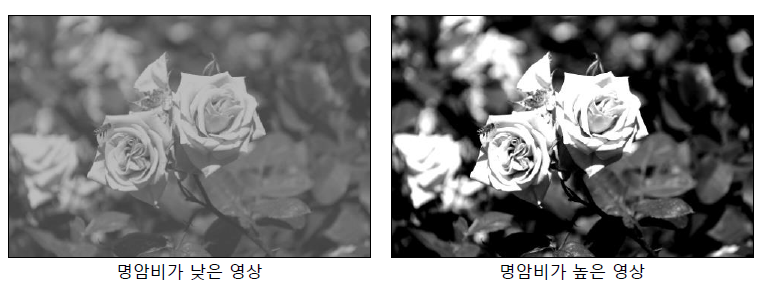

### 기본적인 명암비 조절 함수
- $ dst(x,y) = saturate(s \cdot src(x,y)) $
    - 영상에 곱셈을 해준다. (scaling vector)
    - 이 수식의 문제점은 영상이 어두워지거나 너무 하얗게 되는 경우가 생긴다는 것


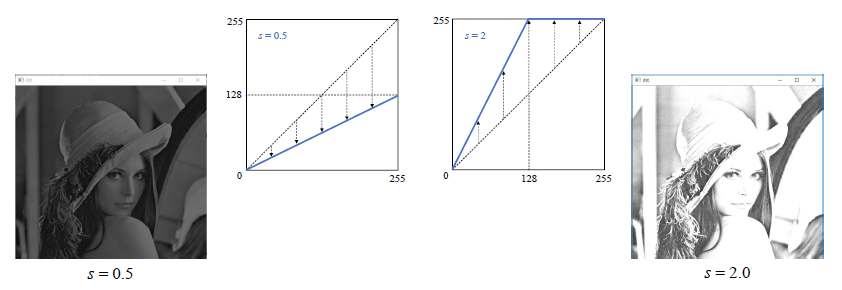

### 효율적인 명암비 조절 함수

$ dst(x,y) = saturate(src(x,y) + (src(x,y)-128) \cdot \alpha) $
- 영상의 pixel 분포가 128부근에 많을 때 효율적인 수식
- 영상이 전체적으로 어둡거나 밝을 때는 효율적인 수식이 아닐 수 있다.
- 경우에 따라서 조절하는 것이 좋다

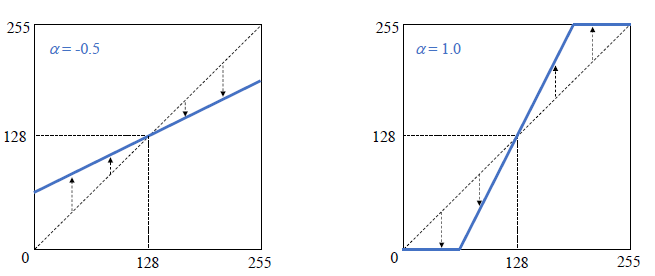

In [5]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
# base_dir
bd = "/content/drive/MyDrive/New_Colab/src/opencv/ch03/"

In [4]:
src = cv2.imread(bd+'lenna.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed')
    sys.exit()

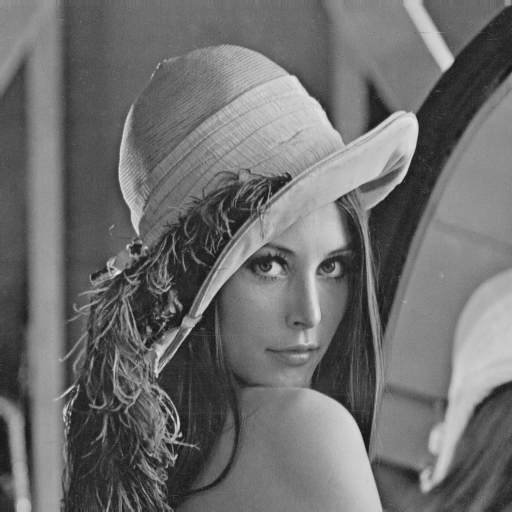

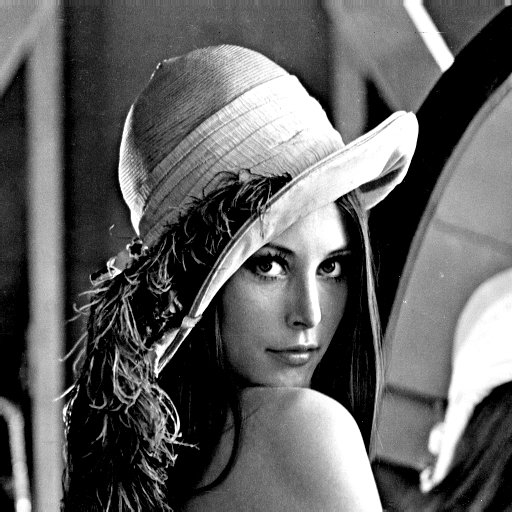

In [6]:
alpha = 1.0
dst = np.clip((1 + alpha) * src - 128*alpha, 0, 255).astype(np.uint8) # 0~255로 clip

cv2_imshow(src)
cv2_imshow(dst)

### 영상의 자동 명암비 조절

- 히스토그램 스트레칭(Histogram stretching)
    - 영상의 히스토그램이 그레이스케일 전 구간에서 걸쳐 나타나도록 변경하는 선형 변환 기법

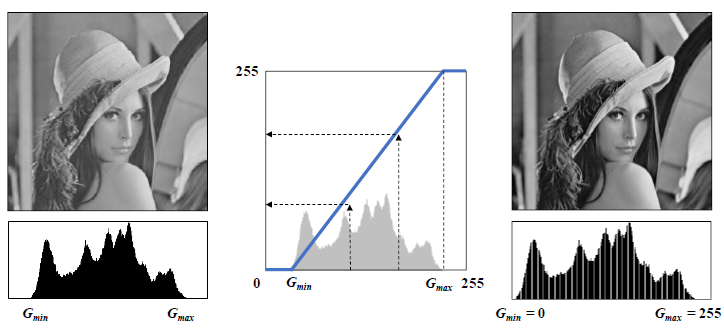

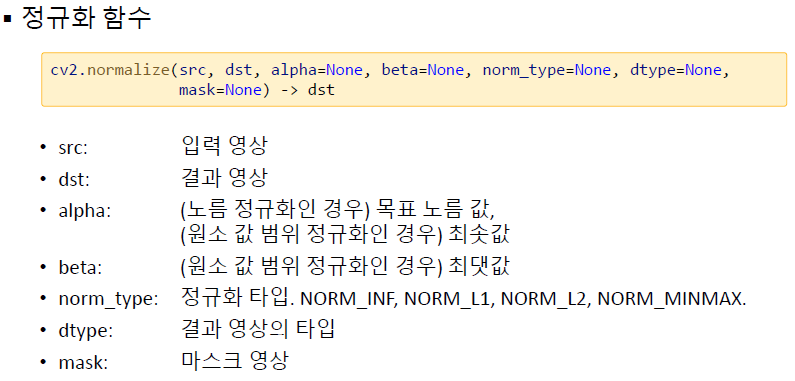

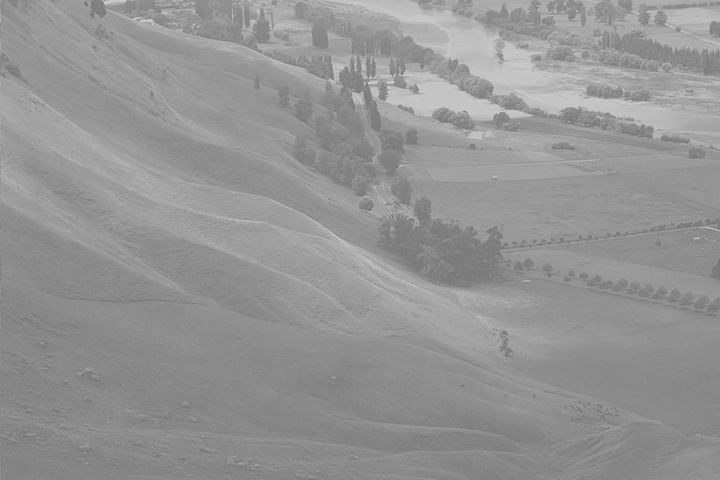

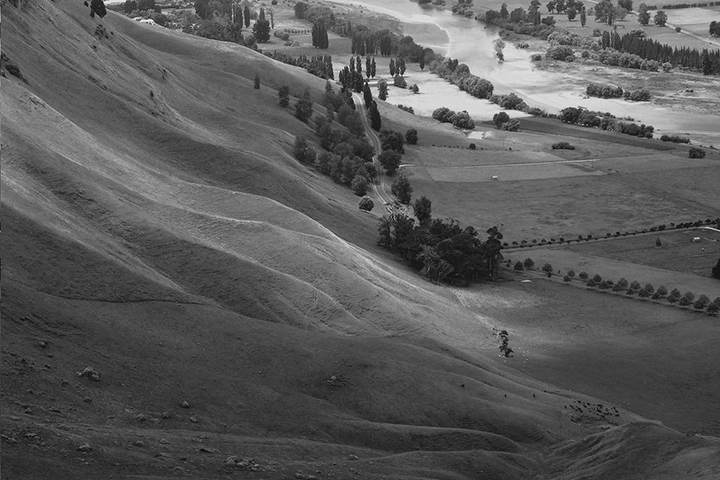

In [7]:
src = cv2.imread(bd+'Hawkes.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed')
    sys.exit()

dst = cv2.normalize(src, None, 0, 255, cv2.NORM_MINMAX)
cv2_imshow(src)
cv2_imshow(dst)

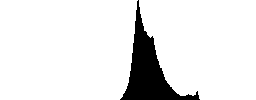

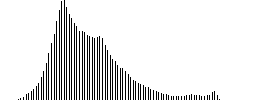

In [9]:
def getGrayHistImage(hist):
    imgHist = np.full((100, 256), 255, dtype=np.uint8)

    histMax = np.max(hist)
    for x in range(256):
        pt1 = (x, 100)
        pt2 = (x, 100 - int(hist[x, 0]*100/histMax))
        cv2.line(imgHist, pt1, pt2, 0)

    return imgHist

hist_src = cv2.calcHist([src], [0], None, [256], [0, 256])
hist_dst = cv2.calcHist([dst], [0], None, [256], [0, 256])
histImg_src = getGrayHistImage(hist_src)
histImg_dst = getGrayHistImage(hist_dst)

cv2_imshow(histImg_src)
cv2_imshow(histImg_dst)

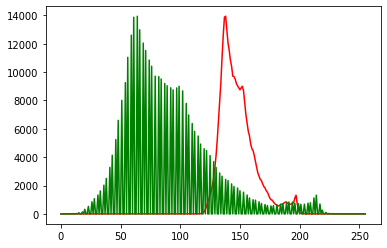

In [13]:
plt.plot(hist_src, 'r', hist_dst, 'g')
plt.show()

### 히스토그램 스트레칭 변환 함수
- 변환 함수의 직선의 방정식 구하기
- 기울기
$$ \frac{255}{G_{max} - G_{min}} $$

- y 절편
$$ -\frac{255\cdot G_{min}}{G_{max} - G_{min}} $$

- 전체 함수
$$ g(x,y) = \frac{255}{G_{max} - G_{min}} \cdot f(x,y) - \frac{255 \cdot G_{min}}{G_{max} - G_{min}} = \frac{f(x,y)-G_{min}}{G_{max} - G_{min}} \cdot 255$$



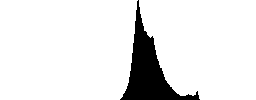

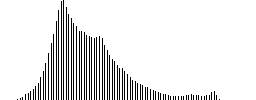

In [14]:
gmin = np.min(src)
gmax = np.max(src)

dst = np.clip((src - gmin)/(gmax-gmin) * 255., 0, 255).astype(np.uint8)

hist_src = cv2.calcHist([src], [0], None, [256], [0, 256])
hist_dst = cv2.calcHist([dst], [0], None, [256], [0, 256])
histImg_src = getGrayHistImage(hist_src)
histImg_dst = getGrayHistImage(hist_dst)

cv2_imshow(histImg_src)
cv2_imshow(histImg_dst)

## 히스토그램 평활화


- 히스토그램 평활화(Histogram equalization)
    - 히스토그램이 그레이스케일 전체 구간에서 균일한 분포로 나타나도록 변경하는 명암비 향상 기법
    - 히스토그램 균등화, 균일화, 평탄화

- 히스토그램 평활하를 위한 변환 함수 구하기
    - 히스토그램 함수 구하기 :
$ h(g) = N_g $

    - 정규화된 히스토그램 함수 구하기:
$ p(g) = \frac{h(g)}{w \times h} $

    - 누적 분포 함수(cdf) 구하기 :
$ cdf(g) = \sum_{0 \le i < g} p(i)$

    - 변환 함수 :
$ dst(x,y) = round(cdf(src(x,y)) \times L_{max}$

### 예시
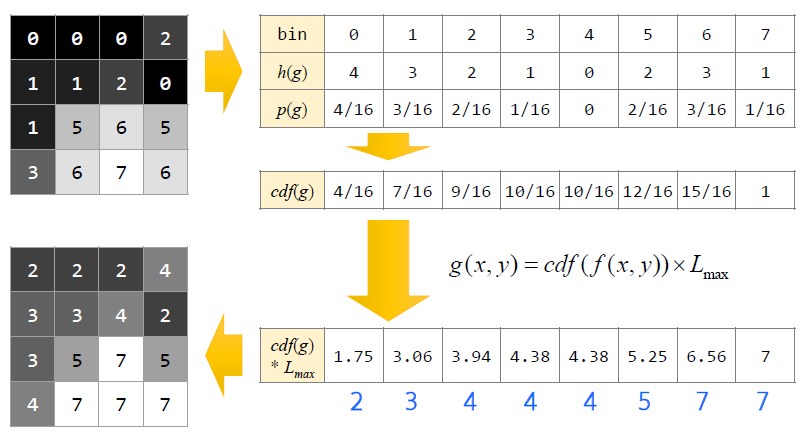

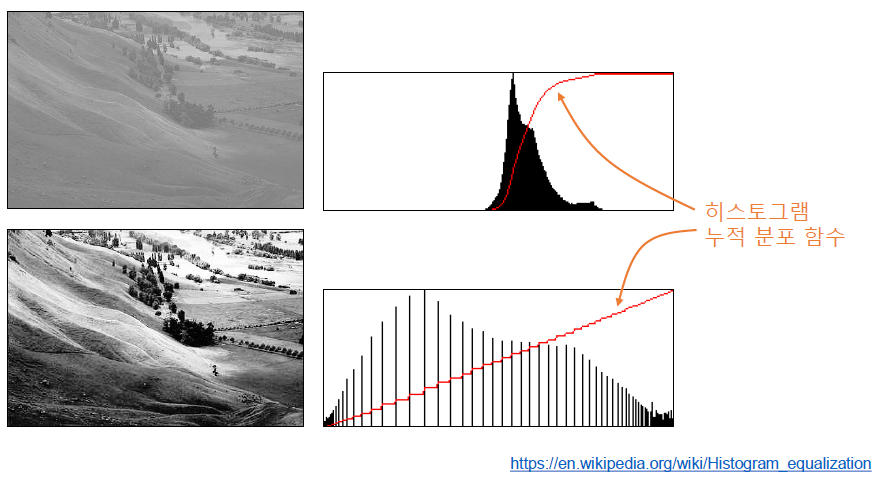

### 그레이스케일 영상의 히스토그램 평활화

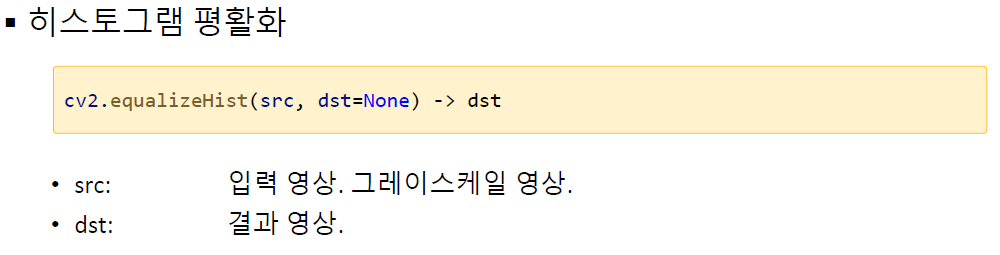

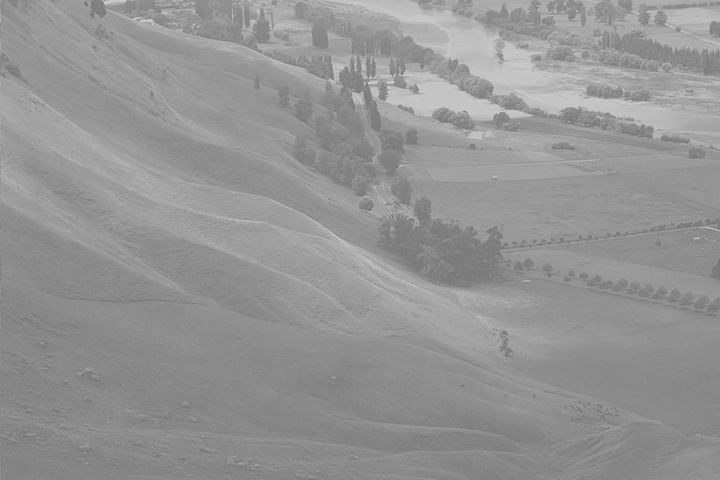

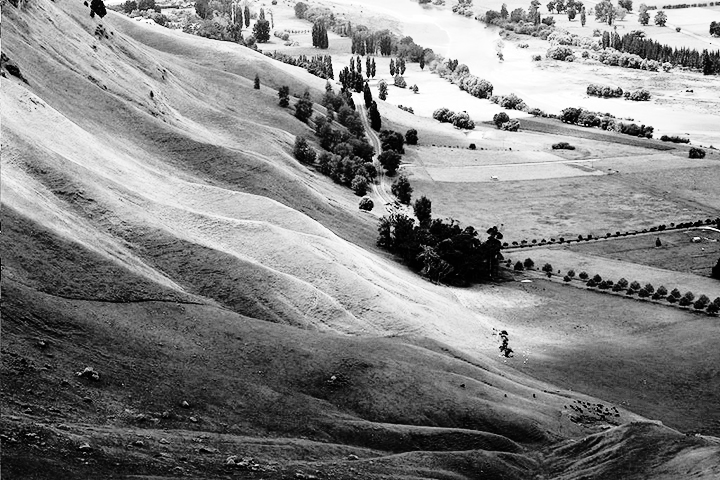

In [16]:
src = cv2.imread(bd+'Hawkes.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed')
    sys.exit()

dst = cv2.equalizeHist(src)

cv2_imshow(src)
cv2_imshow(dst)

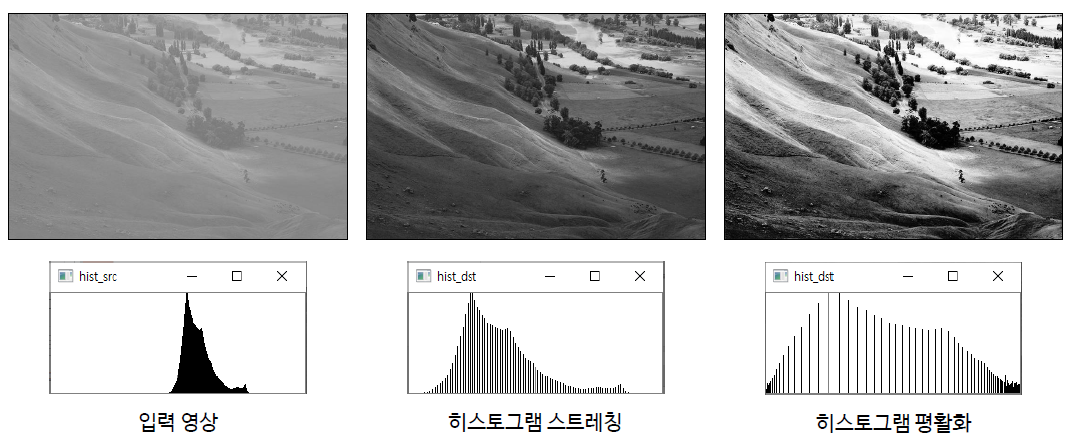

- 히스토그램 스트레칭인 경우 0~255로 넓게 펴는데 간격이 골고루 이미지를 넓히는 것
- 입력 영상 히스토그램에서 뭉쳐져 있는 부분 (가운데 값이 큰것들)이 넓게 펴치고 값이 희소한 곳에선 좁게 펴지는 것

### 컬러 영상의 히스토그램 평활화

cv2.equalizeHist는 그레이스케일 영상만 사용할 수 있다.\
그래서 컬러 영상인 경우 R,G,B로 split해서 각각의 색상 채널을 equalizeHist해줘서 다시 merge해준다고 생각할 수 있다.\
그러나 이러한 경우 색감이 아예 바뀌는 불상사가 생길 수 있다. 그렇다면 어떻게 해야할까?

- YCrCb로 바꿔서 진행하자

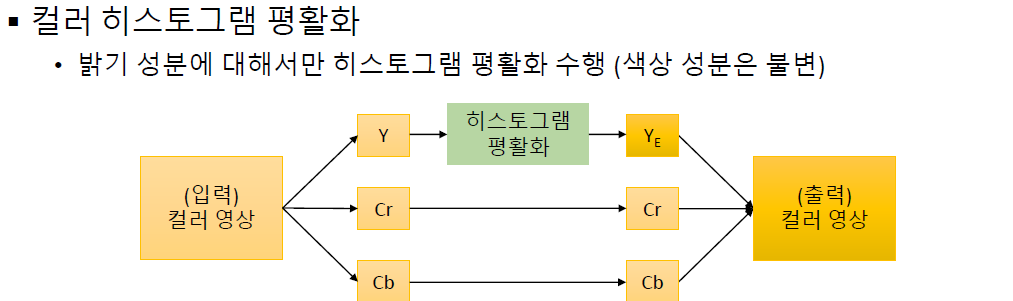

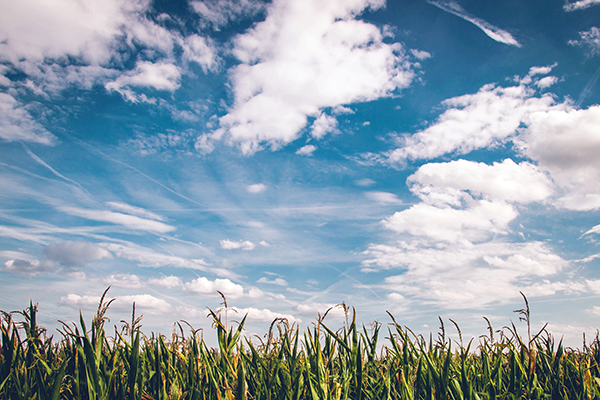

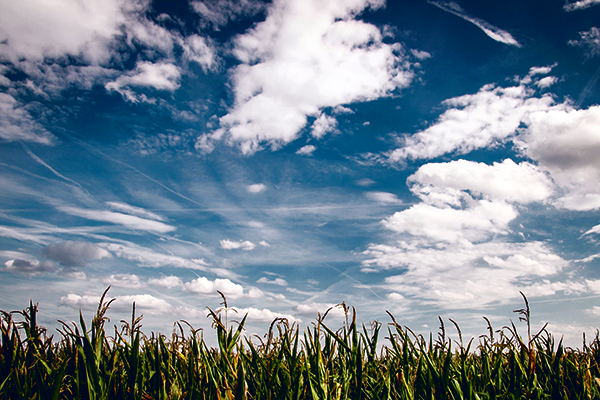

In [17]:
src = cv2.imread(bd+'field.bmp')

if src is None:
    print('Image load failed')
    sys.exit()

# YCrCb로 컨버트
src_ycrcb = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)

# Y, Cr, Cb로 분할
planes = cv2.split(src_ycrcb)

# Y 채널을 히스토그램 평활화 진행
planes[0] = cv2.equalizeHist(planes[0])

# 다시 YCrCb로 합치기
dst_ycrcb = cv2.merge(planes)

# 다시 BGR로 변환
dst = cv2.cvtColor(dst_ycrcb, cv2.COLOR_YCrCb2BGR)

cv2_imshow(src)
cv2_imshow(dst)